In [ ]:
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from torchvision import transforms
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder,DatasetDict

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=180, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(1103, False)

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

xmean = tensor(0.28)
xstd = tensor(0.35)

@inplace
def transformi(b):
    b["image"] = [(TF.to_tensor(i) - xmean) / xstd for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 512
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
cbs = [DeviceCB()]

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop):
    return tfm_x(b[0]), tfm_y(b[1])

In [ ]:
class TopLossesCurriculumCB(Callback):
    def __init__(self, sampler):
        fc.store_attr()
        self.top_losses = [float("inf")] * sampler.num_samples

    def after_batch(self, learn):
        if learn.training:
            losses = to_cpu(F.cross_entropy(learn.preds, learn.batch[1], reduction="none"))
            for idx, loss in enumerate(losses):
                self.top_losses[self.sampler.sampled[idx]] = loss
            self.sampler.sampled = []
    
    def after_epoch(self, learn):
        if learn.training:
            self.sampler.reset_order(self.top_losses)

class TopLossesCurriculumSampler(torch.utils.data.RandomSampler):
    def __init__(self, *args, schedule=[0.2, 0.3, 0.4, 0.5, 0.6], **kwargs):
        super().__init__(*args, **kwargs)
        self.schedule = schedule
        self.cur = 0
        self.reset_order(None)
    
    def reset_order(self, top_losses):
        if top_losses is None:
            self.order = torch.randperm(self.num_samples)
        else:
            if isinstance(self.schedule, float):
                bottom = self.schedule
            else:
                bottom = self.schedule[self.cur]
                self.cur = min((self.cur + 1), len(self.schedule) - 1)
            n = int(len(top_losses)*bottom)
            self.order = torch.argsort(torch.tensor(top_losses), descending=True)[:-n].tolist()
            self.order = self.order[:n] + self.order
            self.order = torch.tensor(self.order)[torch.randperm(len(self.order))]
    
    def __iter__(self):
        self.sampled = []
        while True:
            for sample in self.order:
                self.sampled.append(sample)
                yield sample


def get_top_loss_curriculum(bs, ds=dst, schedule=0.2):
    top_sampler = TopLossesCurriculumSampler(ds["train"], schedule=schedule)
    top_cb = TopLossesCurriculumCB(top_sampler)
    dls = DataLoaders(
        DataLoader(ds["train"], batch_size=bs, collate_fn=collate_dict(ds["train"]), num_workers=0, sampler=top_sampler),
        DataLoader(ds["test"], batch_size=bs, collate_fn=collate_dict(ds["test"]), num_workers=4, shuffle=False),
    )
    return dls, top_cb

In [ ]:
def tta_pred(learn, cbs=[]):
    aug_tta = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_valid=True)
    
    preds1 = CapturePreds()
    learn.fit(1, cbs=[preds1]+cbs, train=False)
    preds2 = CapturePreds()
    learn.fit(1, cbs=[preds2, aug_tta]+cbs, train=False)

    tta_preds = torch.stack((torch.cat(preds1.captured_preds), torch.cat(preds2.captured_preds))).mean(0).argmax(1)
    targets = torch.cat(preds1.captured_targets)
    return (tta_preds == targets).float().mean().item()

In [ ]:
def mix_up(x, ratio, num_classes):
    if x.dtype == torch.long and len(x.shape) == 1:
        x = F.one_hot(x, num_classes)
    return x * ratio + x.roll(1, dims=0) * (1 - ratio)

class MixUp(nn.Module):
    def __init__(self, ratio, num_classes): super().__init__(); fc.store_attr()

    def forward(self, x):
        return mix_up(x, self.ratio, self.num_classes)

In [ ]:
to_drop = {
    36978, 41029, 34456, 37962, 37703, 12706, 35223, 11036, 42395, 20842, 34381, 46125, 28341, 16691,  1087, 40513, 40187, 58618, 39620, 56683, 28635, 16350, 44798, 18875,
    33590, 42110, 42018,  9495, 33982, 40015, 43195,  9588, 32066, 25372, 28764, 30206, 16528,  2468, 44342, 55829, 27550, 19086, 13365, 49712, 46211,  7165, 13103,  2843,
    34598, 12190, 26226, 11885, 58341, 43248, 13380, 54839, 27350,  7001,  1106, 16003, 13138, 40753, 20487, 20858, 25419, 55534, 15955, 56601, 16747
}

In [ ]:
def remap(x, idx):
    if idx in to_drop:
        x["label"] = remapping[idx]
    return x

dst_remapped = DatasetDict(ds.copy())
dst_remapped["train"] = ds["train"].filter(lambda x, idx: idx not in to_drop, with_indices=True)
dst_remapped = dst_remapped.with_transform(transformi)
dst_remapped, ds

(DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 59931
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }))

# Dropout2D

In [ ]:
class Dropout2D(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = 1 - p
        self.mult = 1 / self.p

    def forward(self, x):
        if not self.training:
            return x
        dist = distributions.binomial.Binomial(tensor(1., device=x.device), probs=self.p)
        c = x.shape[1]
        mask = dist.sample((c,)).reshape(1, -1, 1, 1)
        return x * mask * self.mult

In [ ]:
set_seed(1103)
x = torch.ones((1, 3, 2, 1))
print(x)
print(Dropout2D(0.9999)(x))
print(Dropout2D(0.5)(x))

tensor([[[[1.],
          [1.]],

         [[1.],
          [1.]],

         [[1.],
          [1.]]]])
tensor([[[[0.],
          [0.]],

         [[0.],
          [0.]],

         [[0.],
          [0.]]]])
tensor([[[[0.],
          [0.]],

         [[0.],
          [0.]],

         [[2.],
          [2.]]]])


In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d, p_dropout=0.0, init_zero=False, leak=0.0003):
    model = nn.Sequential(ResBlock(1, nfs[0], ks=5, stride=1, act=act, norm=norm))
    if p_dropout > 0.: model.append(Dropout2D(p_dropout))
    for i in range(len(nfs) - 1): model.append(ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm))
    model.append(nn.AdaptiveAvgPool2d(1))
    model.append(nn.Flatten())
    if p_dropout > 0.: model.append(nn.Dropout(p=p_dropout))
    model.append(nn.Linear(nfs[-1], 10, bias=False))
    model.append(nn.BatchNorm1d(10))

    model = model.apply(partial(init_weights, leak=leak))
    if init_zero:
        for l in model[:-5]:
            init.zeros_(l.convs[-1][0].weight)
            init.zeros_(l.convs[-1][0].bias)
    return model

loss,epoch,train
0.734,0,train
0.681,0,valid
0.663,1,train
0.495,1,valid
0.586,2,train
0.501,2,valid
0.504,3,train
0.452,3,valid
0.425,4,train
0.438,4,valid


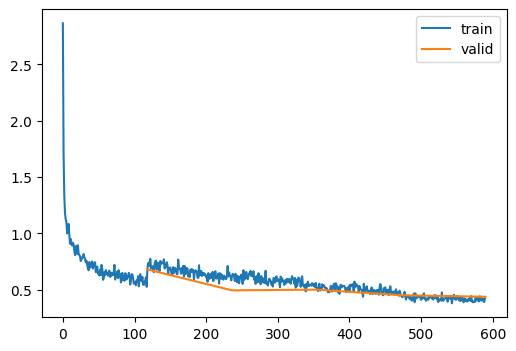

{'accuracy': '0.939', 'loss': '0.438', 'epoch': 0, 'train': 'valid'}
{'accuracy': '0.938', 'loss': '0.443', 'epoch': 0, 'train': 'valid'}


0.9413999915122986

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs, cbs=[MetricsCB(), ProgressCB(True)])
tta_pred(learn, [MetricsCB(accuracy=MulticlassAccuracy())])

loss,epoch,train
0.756,0,train
0.678,0,valid
0.691,1,train
0.588,1,valid
0.593,2,train
0.521,2,valid
0.510,3,train
0.455,3,valid
0.434,4,train
0.440,4,valid


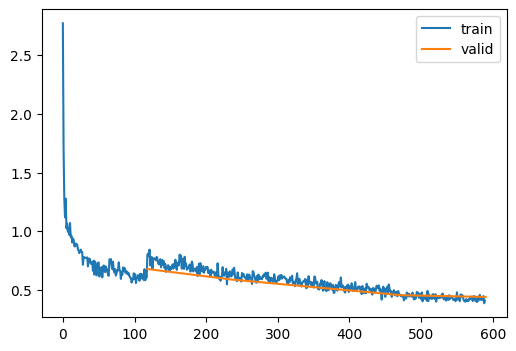

{'accuracy': '0.938', 'loss': '0.440', 'epoch': 0, 'train': 'valid'}
{'accuracy': '0.936', 'loss': '0.445', 'epoch': 0, 'train': 'valid'}


0.9394999742507935

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, ds=dst_remapped, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs, cbs=[MetricsCB(), ProgressCB(True)])
tta_pred(learn, [MetricsCB(accuracy=MulticlassAccuracy())])

In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d, p_dropout=0.0, init_zero=False, leak=0.0003):
    model = nn.Sequential(ResBlock(1, nfs[0], ks=5, stride=1, act=act, norm=norm))
    if p_dropout > 0.: model.append(nn.Dropout2d(p_dropout))
    for i in range(len(nfs) - 1): model.append(ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm))
    model.append(nn.AdaptiveAvgPool2d(1))
    model.append(nn.Flatten())
    if p_dropout > 0.: model.append(nn.Dropout(p=p_dropout))
    model.append(nn.Linear(nfs[-1], 10, bias=False))
    model.append(nn.BatchNorm1d(10))

    model = model.apply(partial(init_weights, leak=leak))
    if init_zero:
        for l in model[:-5]:
            init.zeros_(l.convs[-1][0].weight)
            init.zeros_(l.convs[-1][0].bias)
    return model

loss,epoch,train
0.731,0,train
0.635,0,valid
0.660,1,train
0.505,1,valid
0.582,2,train
0.489,2,valid
0.499,3,train
0.443,3,valid
0.420,4,train
0.438,4,valid


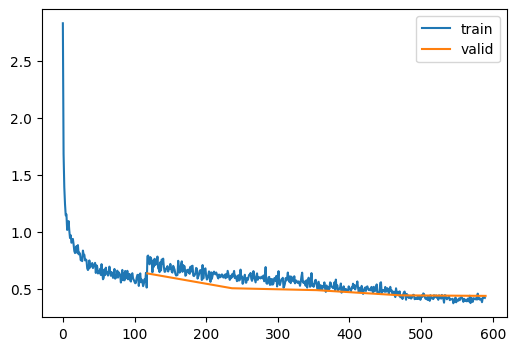

{'accuracy': '0.937', 'loss': '0.438', 'epoch': 0, 'train': 'valid'}
{'accuracy': '0.938', 'loss': '0.442', 'epoch': 0, 'train': 'valid'}


0.9391999840736389

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs, cbs=[MetricsCB(), ProgressCB(True)])
tta_pred(learn, [MetricsCB(accuracy=MulticlassAccuracy())])

loss,epoch,train
0.740,0,train
0.599,0,valid
0.663,1,train
0.560,1,valid
0.577,2,train
0.474,2,valid
0.494,3,train
0.454,3,valid
0.418,4,train
0.443,4,valid


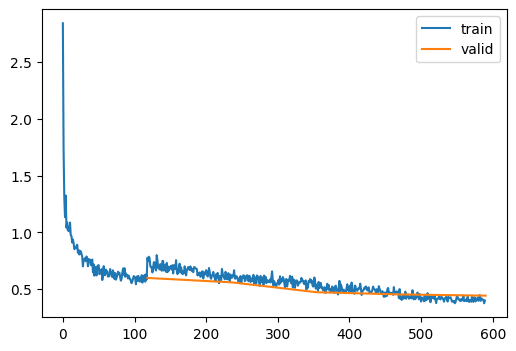

{'accuracy': '0.939', 'loss': '0.443', 'epoch': 0, 'train': 'valid'}
{'accuracy': '0.939', 'loss': '0.443', 'epoch': 0, 'train': 'valid'}


0.9416999816894531

In [ ]:
set_seed(1103, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, ds=dst_remapped, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

model = get_model(act=nn.Mish, nfs=[16,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs, cbs=[MetricsCB(), ProgressCB(True)])
tta_pred(learn, [MetricsCB(accuracy=MulticlassAccuracy())])

loss,epoch,train
0.732,0,train
0.660,0,valid
0.665,1,train
0.539,1,valid
0.589,2,train
0.474,2,valid
0.506,3,train
0.441,3,valid
0.427,4,train
0.439,4,valid


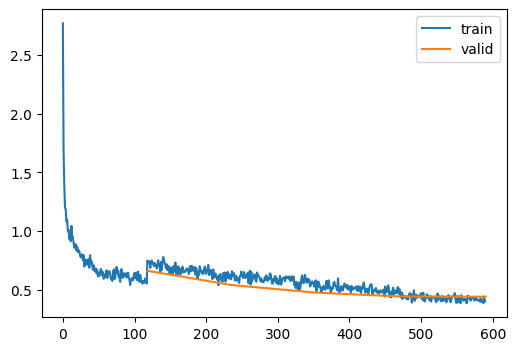

{'accuracy': '0.939', 'loss': '0.439', 'epoch': 0, 'train': 'valid'}
{'accuracy': '0.939', 'loss': '0.438', 'epoch': 0, 'train': 'valid'}


0.9415000081062317

In [ ]:
set_seed(1, False)

epochs = 5
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
transform = nn.Sequential(
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1, False)
model = get_model(act=nn.Mish, nfs=[32,256,256,256,256,256], init_zero=False, p_dropout=0.05)
learn = TrainLearner(model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb,augment,sched], opt_func=optim.AdamW)
learn.fit(epochs, cbs=[MetricsCB(), ProgressCB(True)])
tta_pred(learn, [MetricsCB(accuracy=MulticlassAccuracy())])

loss,epoch,train
1.347,0,train
0.691,0,valid
1.217,1,train
0.700,1,valid
1.175,2,train
0.596,2,valid
1.121,3,train
0.589,3,valid
1.109,4,train
0.560,4,valid


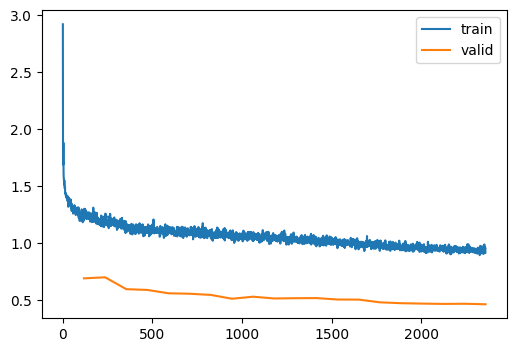

{'accuracy': '0.944', 'loss': '0.464', 'epoch': 0, 'train': 'valid'}
{'accuracy': '0.942', 'loss': '0.468', 'epoch': 0, 'train': 'valid'}


0.9449999928474426

In [ ]:
set_seed(1, False)

epochs = 20
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
mixup = MixUp(0.3, 10)
transform = nn.Sequential(
    transforms.RandomHorizontalFlip(),
    RandSwap(0.1, 2),
    mixup,
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform, tfm_y=mixup), on_valid=False)

set_seed(1, False)
model = get_model(act=nn.Mish, nfs=[32,256,256,256,256,512], init_zero=False, p_dropout=0.05)
learn = TrainLearner(
    model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb, augment, sched], opt_func=optim.AdamW
)
learn.fit(epochs, cbs=[MetricsCB(), ProgressCB(True)])
tta_pred(learn, [MetricsCB(accuracy=MulticlassAccuracy())])

loss,epoch,train
1.444,0,train
0.764,0,valid
1.299,1,train
0.636,1,valid
1.251,2,train
0.629,2,valid
1.214,3,train
0.611,3,valid
1.200,4,train
0.581,4,valid


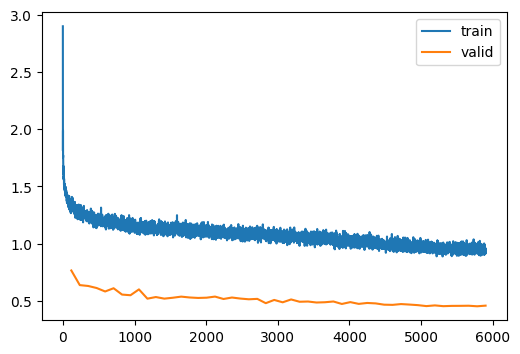

{'accuracy': '0.944', 'loss': '0.457', 'epoch': 0, 'train': 'valid'}
{'accuracy': '0.943', 'loss': '0.460', 'epoch': 0, 'train': 'valid'}


0.946399986743927

In [ ]:
set_seed(1, False)

epochs = 50
lr = 0.05
dls, top_cb = get_top_loss_curriculum(512, schedule=0.2)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.15))
mixup = MixUp(0.35, 10)
transform = nn.Sequential(
    transforms.RandomHorizontalFlip(),
    RandSwap(0.15, 3),
    mixup,
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform, tfm_y=mixup), on_valid=False)

set_seed(1, False)
model = get_model(act=nn.Mish, nfs=[32,256,256,256,256,512], init_zero=False, p_dropout=0.1)
learn = TrainLearner(
    model, dls, partial(F.cross_entropy, label_smoothing=0.05), lr=lr, cbs=cbs+[top_cb, augment, sched], opt_func=optim.AdamW
)
learn.fit(epochs, cbs=[MetricsCB(), ProgressCB(True)])
tta_pred(learn, [MetricsCB(accuracy=MulticlassAccuracy())])